# Primary analyses of our sequences
### Load modules

In [1]:
import os
import sys

In [2]:
!pip install geopandas

  Using cached geopandas-1.0.1-py3-none-any.whl.metadata (2.2 kB)
  Using cached pyogrio-0.10.0-cp39-cp39-manylinux_2_28_x86_64.whl.metadata (5.5 kB)
  Using cached pyproj-3.6.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (31 kB)
  Using cached shapely-2.0.6-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.0 kB)
Using cached geopandas-1.0.1-py3-none-any.whl (323 kB)
Using cached pyogrio-0.10.0-cp39-cp39-manylinux_2_28_x86_64.whl (23.9 MB)
Using cached pyproj-3.6.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.3 MB)
Using cached shapely-2.0.6-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.5 MB)


In [3]:
!pip install cartopy

  Using cached Cartopy-0.23.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.0 kB)
  Using cached pyshp-2.3.1-py2.py3-none-any.whl.metadata (55 kB)
Using cached Cartopy-0.23.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.6 MB)
Using cached pyshp-2.3.1-py2.py3-none-any.whl (46 kB)


In [4]:
import pandas as pd
import qiime2 as q2
from qiime2 import Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import cartopy.crs as ccrs
%matplotlib inline

# Define the data directory
data_dir = './data'

### Checking out the metadata

In [5]:
!qiime metadata tabulate \
  --m-input-file ./data/metadata/fungut_metadata.tsv \
  --o-visualization ./data/metadata/fungut_metadata.qzv

Saved Visualization to: ./data/metadata/fungut_metadata.qzv


In [ ]:
Visualization.load('./data/metadata/fungut_metadata.qzv')

# Preprocessing the metadata

### Removing rows with NaN for Diseases

In [5]:
#read metadata
metadata = pd.read_csv("./data/metadata/fungut_metadata.tsv", sep="\t")

In [6]:
#count the rows that have column "ibd_sample" and "gluten_sample" = Not provided
filtered_rows = metadata[(metadata['ibd_sample'] == "Not provided") & (metadata['gluten_sample'] == "Not provided")]
print(len(filtered_rows), "samples have both response variables not provided")

#filter rows that have column "ibd_sample" and "gluten_sample" = Not provided
metadata = metadata[~((metadata['ibd_sample'] == "Not provided") & (metadata['gluten_sample'] == "Not provided"))]
metadata.describe()
print(len(filtered_rows), "samples have been removed")

4 samples have both response variables not provided
4 samples have been removed


### How many "Not Provided" do we have per sample?

In [7]:
# count the number of rows that have more than x columns not provided
for x in range(1, 7):
    count = metadata[metadata.eq("Not provided").sum(axis=1) >= x].shape[0]
    print(f"{count:02} samples have 'Not Provided' for {x} columns")

62 samples have 'Not Provided' for 1 columns
10 samples have 'Not Provided' for 2 columns
05 samples have 'Not Provided' for 3 columns
02 samples have 'Not Provided' for 4 columns
01 samples have 'Not Provided' for 5 columns
00 samples have 'Not Provided' for 6 columns


#### We do not filter out any of these samples. the 5 missing columns in one sample is fine.

### Create new features "Symptoms vs No-Symptoms"

In [8]:
metadata['gluten_sample'].unique()

array(['No',
       'I was diagnosed with gluten allergy (anti-gluten IgG), but not celiac disease',
       'I do not eat gluten because it makes me feel bad',
       'I was diagnosed with celiac disease', 'Not provided'],
      dtype=object)

In [9]:
metadata['ibd_sample'].unique()

array(['I do not have this condition', 'Self-diagnosed',
       'Diagnosed by a medical professional (doctor, physician assistant)',
       'Not provided'], dtype=object)

We have 2 columns where the people from our data set state wheter they are diagnosed with Inflammatory Bowel Disease and how they react to gluten . Because the answers are not that easy to compare against each other, we create a new column which summarizes whether a person shows symptoms or not (2 separate, one for gluten and one for IBD). This way we have a binary variable that creates 2 groups which is easier to compare. We also have the problem, that most of the people have answer "No" and the other groups are much smaller. When we group all people together that show symptoms we have one bigger group instead of 3 smaller ones.

In [10]:
# Define the categories to summarize as "symptoms"
no_symptoms = ['I do not have this condition']  

# Create a new column with a binary classification
metadata['ibd_symptoms'] = metadata['ibd_sample'].apply(
    lambda x: 'Not provided' if x == 'Not provided' else 
              ('no_symptoms' if x in no_symptoms else 'symptoms')
)

In [11]:
# Define the categories to summarize as "no_symptoms"
no_symptoms = ['No']  

# Create a new column with a binary classification
metadata['gluten_symptoms'] = metadata['gluten_sample'].apply(
    lambda x: 'Not provided' if x == 'Not provided' else 
              ('no_symptoms' if x in no_symptoms else 'symptoms')
)

### Add new feature "is_urban"
Within the metadata we have for each sample the longitude and lattidude. From this we can get the  location where a person lives (roughly). We want to distinguish between rural areas and urban areas. Therefore we classify every location from a sample whether it is rural or urban with help of the packages 'geopandas' and 'carotpy'. 

In [12]:
# Create a boolean mask for rows with valid longitude and latitude values
valid_coords = (metadata['longitude_sample'] != "Not provided") & (metadata['latitude_sample'] != "Not provided")

# Initialize the 'is_urban' column with "Not provided"
metadata['is_urban'] = "Not provided"

# Process only rows with valid longitude and latitude
valid_metadata = metadata[valid_coords]

# Convert valid latitude and longitude columns to a GeoDataFrame
gdf = gpd.GeoDataFrame(valid_metadata, 
                       geometry=gpd.points_from_xy(valid_metadata['longitude_sample'].astype(float), 
                                                   valid_metadata['latitude_sample'].astype(float)), 
                       crs="EPSG:4326")

# Load the shapefile for urban areas
urban_areas = gpd.read_file('./data/urban_areas/ne_10m_urban_areas.shp')

# Perform the spatial join for valid rows
gdf['is_urban'] = gpd.sjoin(gdf, urban_areas, predicate='within', how='left').index_right.notnull()

# Update the 'is_urban' column in the original metadata DataFrame
metadata.loc[valid_coords, 'is_urban'] = gdf['is_urban'].astype(bool)

In [13]:
metadata.head()

,ID,country_sample,state_sample,latitude_sample,longitude_sample,sex_sample,age_years_sample,height_cm_sample,weight_kg_sample,bmi_sample,diet_type_sample,ibd_sample,gluten_sample,ibd_symptoms,gluten_symptoms,is_urban
0,ERR5327198,USA,TN,36.1,-86.8,female,67,152,41,17.75,Omnivore,I do not have this condition,No,no_symptoms,no_symptoms,True
1,ERR5327199,USA,DC,38.9,-77.1,male,55.0,182.0,79.0,23.73,Omnivore,I do not have this condition,I was diagnosed with gluten allergy (anti-glut...,no_symptoms,symptoms,True
2,ERR5327266,USA,VA,38.9,-77.1,female,28.0,175.0,61.0,19.94,Omnivore,I do not have this condition,I do not eat gluten because it makes me feel bad,no_symptoms,symptoms,True
3,ERR5327282,United Kingdom,Not provided,51.6,-0.2,female,26.0,166.0,60.0,21.77,Omnivore,I do not have this condition,No,no_symptoms,no_symptoms,True
4,ERR5327284,United Kingdom,Not provided,51.5,-0.2,female,25.0,173.0,59.0,20.01,Vegetarian but eat seafood,I do not have this condition,No,no_symptoms,no_symptoms,True


### Categorize people based on their ages
We are going to bin by age groups. The first age group will be 0-2 years old infants because their gut microbiota will be different. The next group is 3-10, so children. 10-20 is the next group for adolescents/ early adulthood. 20-40 is the next one for the adults. 40-60 for the late adult stages and 60+ for the elderly.


In [14]:
# Ensure the column is numeric
metadata['age_years_sample'] = pd.to_numeric(metadata['age_years_sample'], errors='coerce')

# Handle missing values in the column
metadata['age_years_sample'].fillna(-1, inplace=True)

# Define bins and labels
bins = [-1, 0, 2, 10, 20, 40, 60, float('inf')]
labels = ["Others", "Infant", "Child", "Adolescent", "Adult", "Older Adult", "Senior"]

# Create the age_group column
metadata['age_group'] = pd.cut(metadata['age_years_sample'], bins=bins, labels=labels, right=False)

# Check the result
print(metadata[['age_years_sample', 'age_group']].head())


   age_years_sample    age_group
0              67.0       Senior
1              55.0  Older Adult
2              28.0        Adult
3              26.0        Adult
4              25.0        Adult


/tmp/ipykernel_377/3890929446.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  metadata['age_years_sample'].fillna(-1, inplace=True)


### Categorize people based on their BMI
According to the national institute of health: https://www.nhlbi.nih.gov/health/educational/lose_wt/BMI/bmicalc.htm#:~:text=BMI%20Categories%3A,BMI%20of%2030%20or%20greater the weights are categorized this way:  
Underweight = <18.5  
Normal weight = 18.5–24.9  
Overweight = 25–29.9  
Obesity = BMI of 30 or greater

In [15]:
metadata['bmi_sample'] = pd.to_numeric(metadata['bmi_sample'], errors='coerce')

# Define BMI bins and labels
bmi_bins = [float('-inf'), 18.5, 24.9, 29.9, float('inf')]
bmi_labels = ["Underweight", "Normal weight", "Overweight", "Obesity"]

# Create the bmi_category column
metadata['bmi_category'] = pd.cut(metadata['bmi_sample'], bins=bmi_bins, labels=bmi_labels, right=False)

# Fill missing values in bmi_category with "Others"
metadata['bmi_category'] = metadata['bmi_category'].cat.add_categories("Others").fillna("Others")

In [16]:
# Check that everything looks as expected
metadata.head()

,ID,country_sample,state_sample,latitude_sample,longitude_sample,sex_sample,age_years_sample,height_cm_sample,weight_kg_sample,bmi_sample,diet_type_sample,ibd_sample,gluten_sample,ibd_symptoms,gluten_symptoms,is_urban,age_group,bmi_category
0,ERR5327198,USA,TN,36.1,-86.8,female,67.0,152,41,17.75,Omnivore,I do not have this condition,No,no_symptoms,no_symptoms,True,Senior,Underweight
1,ERR5327199,USA,DC,38.9,-77.1,male,55.0,182.0,79.0,23.73,Omnivore,I do not have this condition,I was diagnosed with gluten allergy (anti-glut...,no_symptoms,symptoms,True,Older Adult,Normal weight
2,ERR5327266,USA,VA,38.9,-77.1,female,28.0,175.0,61.0,19.94,Omnivore,I do not have this condition,I do not eat gluten because it makes me feel bad,no_symptoms,symptoms,True,Adult,Normal weight
3,ERR5327282,United Kingdom,Not provided,51.6,-0.2,female,26.0,166.0,60.0,21.77,Omnivore,I do not have this condition,No,no_symptoms,no_symptoms,True,Adult,Normal weight
4,ERR5327284,United Kingdom,Not provided,51.5,-0.2,female,25.0,173.0,59.0,20.01,Vegetarian but eat seafood,I do not have this condition,No,no_symptoms,no_symptoms,True,Adult,Normal weight


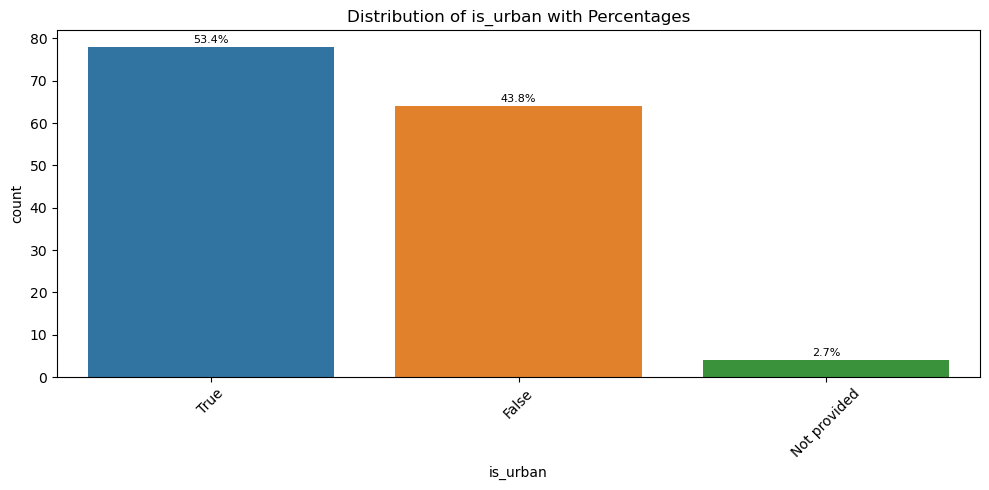

/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


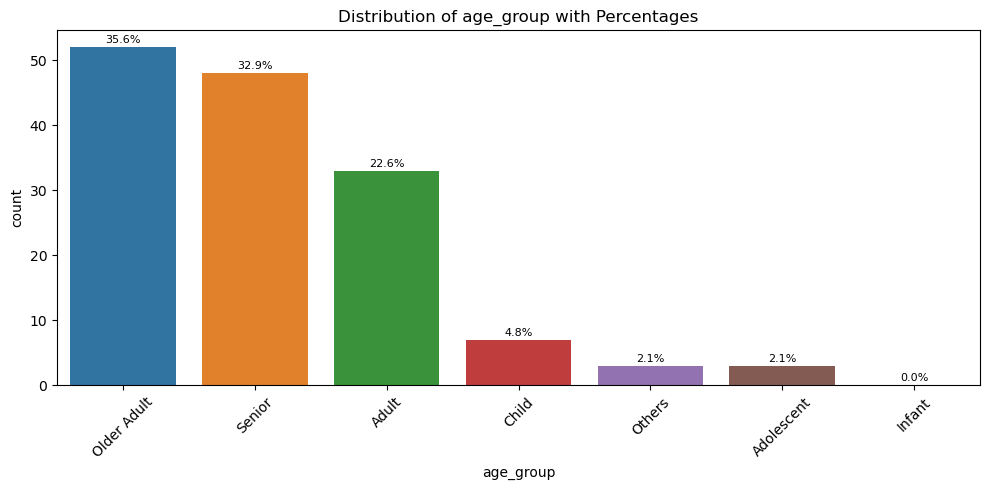

/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


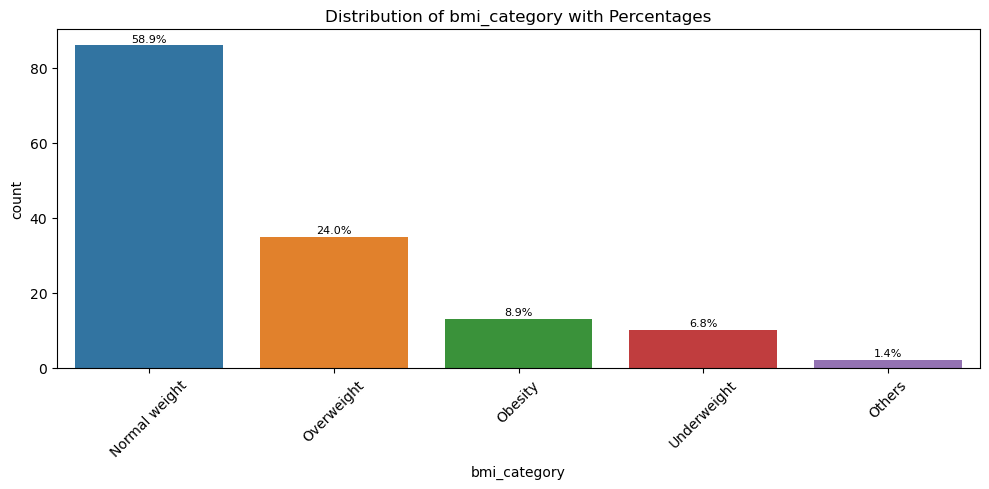

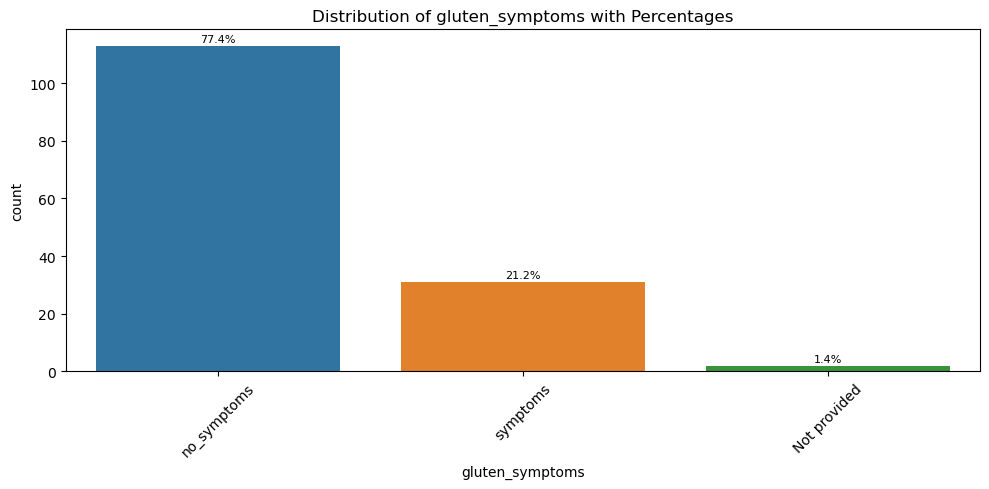

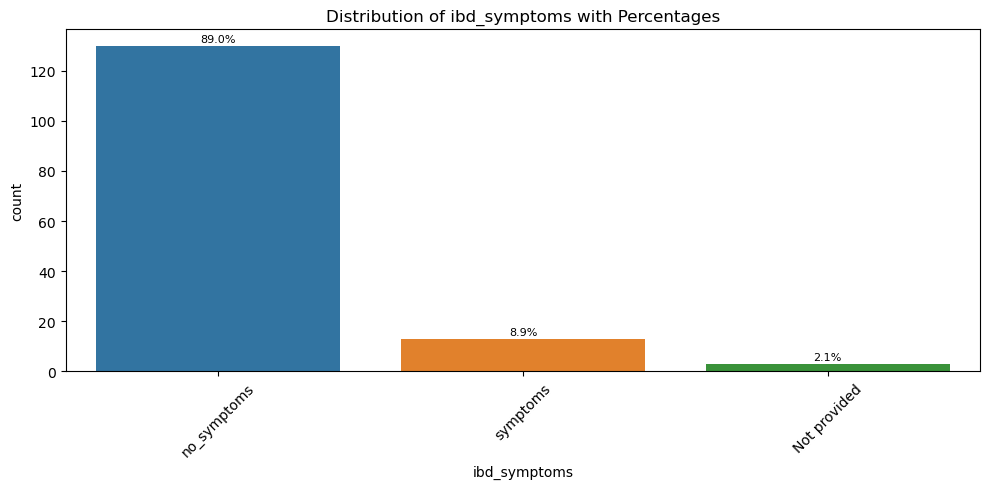

In [18]:
categorical_cols = ['is_urban', 'age_group', 'bmi_category', 'gluten_symptoms', 'ibd_symptoms']
# Bar plot with percentage annotations
for col in categorical_cols:
    plt.figure(figsize=(10, 5))
    ax = sns.countplot(x=metadata[col], order=metadata[col].value_counts().index)
    total = len(metadata[col])
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * (p.get_height() / total))
        ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize = 8)
    plt.title(f'Distribution of {col} with Percentages')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'./plots/distribution_of_{col}.png')
    plt.show()


### Save processed metadata as tsv file

In [28]:
metadata.to_csv('./data/metadata/fungut_metadata_processed.tsv', sep='\t', index=False)

/tmp/ipykernel_1143/792380844.py:19: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


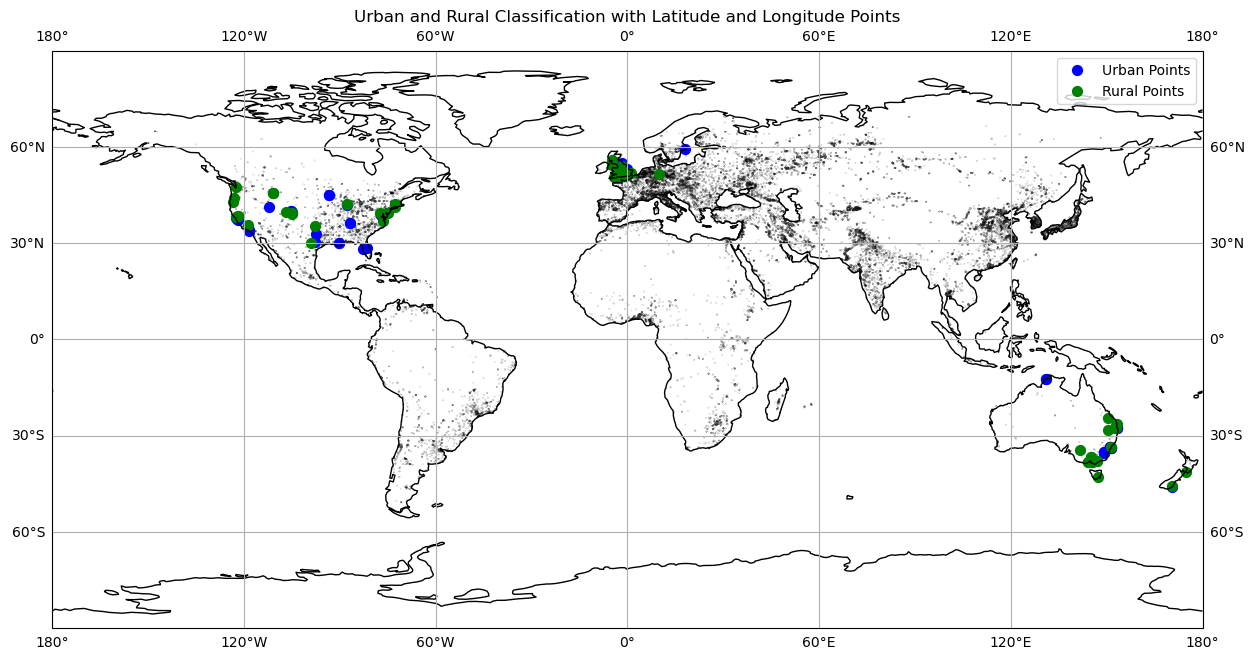

In [29]:
# Split up the points into urban and rural for later plotting
urban_points = gdf[gdf['is_urban']]
rural_points = gdf[~gdf['is_urban']]

# Create a figure with the Cartopy PlateCarree projection
fig, ax = plt.subplots(figsize=(15, 7.5), subplot_kw={'projection': ccrs.PlateCarree()})

ax.set_global() # display the whole world map
ax.coastlines() # display the coastline
ax.gridlines(draw_labels=True)

# Plot the urban areas shapefile
urban_areas.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.6, label='Urban Area')

# Plot the urban and rural points
urban_points.plot(ax=ax, color='blue', markersize=50, label='Urban Points')
rural_points.plot(ax=ax, color='green', markersize=50, label='Rural Points')

plt.legend()
plt.title('Urban and Rural Classification with Latitude and Longitude Points')
plt.show()
